In [ ]:
!pip install torchtyping

  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.3.0
    Uninstalling typeguard-4.3.0:
      Successfully uninstalled typeguard-4.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.4.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [ ]:
from torchtyping import TensorType, patch_typeguard
from typeguard import typechecked
import torch as th

Scalar = TensorType[()]
patch_typeguard()

## Задачи для совместного разбора

1\. Реализуйте обратное распространение ошибки для модели нейрона с квадратичной функцией потерь при условии, что на вход нейрону поступает вектор `inputs`. Проверьте корректность вычисления градиентов, воспользовавшись возможностями по автоматическому дифференцированию `torch`.

In [ ]:
class Neuron:
    def __init__(self, n_features: int, bias: float, requires_grad: bool = False) -> None:
        # <создать атрибуты объекта weights и bias>
        self.weights: TensorType["n_features"] = th.rand(n_features, requires_grad=requires_grad)
        self.bias: Scalar = th.tensor(bias, requires_grad=requires_grad)

    @typechecked
    def forward(self, inputs: TensorType["n_features"]) -> Scalar:
        return inputs @ self.weights + self.bias

    def backward(self, inputs: TensorType["n_features"], dnext: Scalar):
      self.dweights = dnext * inputs
      self.dbias = dnext
      self.dinputs = dnext * self.weights


In [ ]:
class Loss:
    def forward(
        self,
        y_pred: Scalar,
        y_true: Scalar
    ) -> Scalar:
        return (y_pred - y_true)**2

    def backward(self, y_pred: Scalar, y_true: Scalar) -> Scalar:
      self.dinput = 2 * (y_pred - y_true)

In [ ]:
import torch as th
neuron = Neuron(n_features=2, bias=0.0, requires_grad=True)
criterion = Loss()

inputs = th.tensor([2.0, 3.0])
y_true = th.tensor(10)

# forward pass
y_pred = neuron.forward(inputs)
loss = criterion.forward(y_pred, y_true)

# backprop
criterion.backward(y_pred, y_true)
neuron.backward(inputs, criterion.dinput)

In [ ]:
loss

tensor(34.1588, grad_fn=<PowBackward0>)

In [ ]:
criterion.dinput

tensor(-11.6891, grad_fn=<MulBackward0>)

In [ ]:
neuron.dweights

tensor([-23.3782, -35.0673], grad_fn=<MulBackward0>)

In [ ]:
neuron.dbias

tensor(-11.6891, grad_fn=<MulBackward0>)

In [ ]:
loss.backward()

In [ ]:
neuron.weights.grad

tensor([-23.3782, -35.0673])

In [ ]:
neuron.bias.grad

tensor(-11.6891)

In [ ]:
loss

tensor(34.1588, grad_fn=<PowBackward0>)

2\. Настройте модель нейрона, используя метод стохастического градиентного спуска и собственную реализацию обратного распространения ошибки.

In [ ]:
from sklearn.datasets import make_regression
import numpy as np
import matplotlib.pyplot as plt

X, y, coef = make_regression(n_features=4, n_informative=4, coef=True, bias=0.5, random_state=42)
X = th.FloatTensor(X)
y = th.FloatTensor(y)

In [ ]:
import numpy as np

In [ ]:
neuron = Neuron(n_features=4, bias=0.0, requires_grad=False)
criterion = Loss()
lr = 0.1

for epoch in range(3):
  losses = []
  for x_i, y_i in zip(X, y):
    y_pred = neuron.forward(x_i)
    loss_i = criterion.forward(y_pred, y_i)
    losses.append(loss_i.item())

    criterion.backward(y_pred, y_i)
    neuron.backward(x_i, criterion.dinput)

    neuron.weights -= lr * neuron.dweights
    neuron.bias -= lr * neuron.dbias
  print(f"{epoch} {np.mean(losses)}")

0 609.7316132254444
1 7.822344625822097e-05
2 1.0739416467231422e-10


In [ ]:
neuron.weights

tensor([ 5.6376, 86.4722, 27.3407, 41.4819])

In [ ]:
neuron.bias

tensor(0.5000)

In [ ]:
coef

array([ 5.63754967, 86.47223763, 27.34070719, 41.48195023])

## Задачи для самостоятельного решения

<p class="task" id="1"></p>

1\. Реализуйте обратное распространение ошибки для модели нейрона с функцией потерь MSE при условии, что на вход нейрону поступает пакет (двумерный тензор) `inputs`. Проверьте корректность вычисления градиентов, воспользовавшись возможностями по автоматическому дифференцированию `torch`.

$$\mathbf{X} = \begin{bmatrix}
x_{10} & x_{11} & \ldots & x_{1m} \\
x_{20} & x_{21} & \ldots & x_{2m} \\
\vdots & \vdots & \ddots & \vdots \\
x_{k0} & x_{k1} & \ldots & x_{km} \\
\end{bmatrix}
\mathbf{Y} = \begin{bmatrix}
y_{1} \\
y_{2} \\
\vdots \\
y_{k} \\
\end{bmatrix}
\mathbf{W} = \begin{bmatrix}
w_{0} \\
w_{1} \\
\vdots \\
w_{m} \\
\end{bmatrix}$$

$$\hat{\mathbf{Y}} = \mathbf{X}\times \mathbf{W}$$

$$L = \frac{1}{k}\sum_{k}{(\hat{y_k}-y_k)^2}$$

$$\nabla_{\hat{\mathbf{Y}}} L=\begin{bmatrix}
\frac{\partial L}{\partial \hat{y_1}} \\
\frac{\partial L}{\partial \hat{y_2}} \\
\vdots \\
\frac{\partial L}{\partial \hat{y_k}} \\
\end{bmatrix} = \frac{2}{k}\begin{bmatrix}
\hat{y_1} - y_1 \\
\hat{y_2} - y_2 \\
\vdots \\
\hat{y_k} - y_k \\
\end{bmatrix}$$

$$\boldsymbol{\nabla_{\mathbf{W}} L = \mathbf{X}^T\nabla_{\hat{\mathbf{Y}}} L}$$

- [ ] Проверено на семинаре

In [ ]:
!pip install torchtyping

  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.3.0
    Uninstalling typeguard-4.3.0:
      Successfully uninstalled typeguard-4.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.4.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [ ]:
from torchtyping import TensorType, patch_typeguard
from typeguard import typechecked
import torch as th

Scalar = TensorType[()]
patch_typeguard()

In [ ]:
import torch as th

class NeuronBatch:
    def __init__(self, n_features: int, seed: int | None = None, grad: bool = False):
        if seed is not None:
            th.manual_seed(seed)
        # Добавьте дополнительный вес для сдвига (bias)
        # задайте requires_grad у этого тензора, чтобы иметь возможность протестировать
        # автоматическое дифференцирование от torch
        self.weights: TensorType["n_features_with_bias", 1] = th.rand(n_features+1, requires_grad=grad)

    def add_ones_col(self, inputs: TensorType["batch", "n_features"]) -> TensorType["batch", "n_features_with_bias"]:
        """Добавляет столбец из единиц в начало матрицы inputs"""
        nbatches = inputs.shape[0]
        first_col = th.ones(nbatches).view(nbatches,1)
        inputs_1 = th.cat((first_col, inputs),1)
        return inputs_1

    def forward(self, inputs: TensorType["batch", "n_features"]) -> TensorType["batch", 1]:
        inputs_1 = self.add_ones_col(inputs)
        return inputs_1 @ self.weights

    def backward(self, inputs: TensorType["batch", "n_features+1"], dnext: TensorType["batch", 1]) -> None:
        inputs_1 = self.add_ones_col(inputs)
        self.dweights: TensorType["n_features_with_bias", 1] = inputs_1.T @ dnext
        #self.dinputs = self.weights @ dnext
        #print(inputs_1.T, '\n',self.weights, '\n', dnext)
        # self.dbias = dnext
        # self.dinputs = dnext * self.weights

In [ ]:
class MSELoss:
    def forward(self, y_pred: TensorType["batch", 1], y_true: TensorType["batch", 1]) -> Scalar:
        self.loss = ((y_pred-y_true)**2).mean()
        return self.loss

    def backward(self, y_pred: TensorType["batch", 1], y_true: TensorType["batch", 1]) -> None:
        #dL/dy
        k = y_pred.shape[0]
        #print("los", y_pred.shape)
        self.dinput: TensorType["batch", 1] = -2/k * (y_true-y_pred) #["batch", 1]

In [ ]:
inputs = th.tensor([[-0.2341,  0.7674, -0.2342,  1.5792],
                    [-1.9133, -0.5623,  0.2420, -1.7249],
                    [ 0.3142, -1.4123, -1.0128, -0.9080],
                    [ 0.5426, -0.4657, -0.4695, -0.4634],
                    [-0.1383,  1.5230,  0.4967,  0.6477]])
y_true = th.tensor([ 42.4340, -202.0478, -111.7746,  -11.5135,  103.5495])

n_features = 4
model = NeuronBatch(n_features = n_features, grad=True)
criterion = MSELoss()

y_pred = model.forward(inputs=inputs)
loss = criterion.forward(y_pred, y_true)

criterion.backward(y_pred, y_true) #dL/dy
model.backward(inputs, criterion.dinput) #dL/dw

In [ ]:
# inputs * criterion.dinput

In [ ]:
loss

tensor(13107.0342, grad_fn=<MeanBackward0>)

In [ ]:
criterion.dinput #dL/dy

tensor([-16.5398,  80.6423,  44.8360,   4.9271, -40.9188],
       grad_fn=<MulBackward0>)

In [ ]:
model.dweights #dL/dw

tensor([  72.9467, -128.0009, -185.9735,  -44.6584, -234.7169],
       grad_fn=<MvBackward0>)

In [ ]:
loss.backward()

In [ ]:
model.weights.grad

tensor([  72.9467, -128.0009, -185.9735,  -44.6584, -234.7169])

In [ ]:
model.weights

tensor([0.8425, 0.4839, 0.1216, 0.3110, 0.2120], requires_grad=True)

In [ ]:
# model.dinputs

<p class="task" id="2"></p>

2\. Настройте модель нейрона, используя метод мини-пакетного градиентного спуска.

Используйте обратное распространение ошибки, реализованное самостоятельно. Выведите на экран полученные и правильные коэффициенты модели.

- [ ] Проверено на семинаре

In [ ]:
from sklearn.datasets import make_regression
from torch.utils.data import DataLoader, TensorDataset
import torch as th
import numpy as np

X, y, coef = make_regression(n_features=4, n_informative=4, coef=True, bias=0.5, random_state=42)
X = th.FloatTensor(X)
y = th.FloatTensor(y).reshape(-1, 1)

In [ ]:
dataset = TensorDataset(X, y)
loader = DataLoader(dataset, batch_size=6, shuffle=True)

for batch in loader:
    features, labels = batch
    print(features.shape)
    print(labels.shape)
    break

torch.Size([6, 4])
torch.Size([6, 1])


In [ ]:
neuron = NeuronBatch(n_features=4, grad=False)
criterion = MSELoss()
lr = 0.1

for epoch in range(3):
    losses = []
    for batch in loader:
        features, y_true = batch
        y_true = y_true.view(-1)
        y_pred = neuron.forward(features)

        loss_i = criterion.forward(y_pred, y_true)
        losses.append(loss_i)

        criterion.backward(y_pred, y_true)
        #print(criterion.dinput.shape, features.shape)
        neuron.backward(features, criterion.dinput)
        neuron.weights -= lr * neuron.dweights
    print(f"epoch = {epoch}, mean loss ={np.mean(losses)}")

epoch = 0, mean loss =1839.0113525390625
epoch = 1, mean loss =2.691901206970215
epoch = 2, mean loss =0.0035154458601027727


In [ ]:
print('true bias = ' ,[0.5], 'nn bias', neuron.weights[0])
print('nn weights:',neuron.weights[1:],'\ntrue weights',  coef)

true bias =  [0.5] nn bias tensor(0.4985)
nn weights: tensor([ 5.6373, 86.4731, 27.3419, 41.4752]) 
true weights [ 5.63754967 86.47223763 27.34070719 41.48195023]


<p class="task" id="3"></p>

3\. Реализуйте обратное распространение ошибки для модели полносвязного слоя с функцией потерь MSE при условии, что на вход нейрону поступает пакет (двумерный тензор) `inputs`.  Проверьте корректность вычисления градиентов, воспользовавшись возможностями по автоматическому дифференцированию `torch`.

Обратите внимание, что вам потребуются оба градиента $ \boldsymbol{\nabla_{\mathbf{W}} L }$ и $\boldsymbol{\nabla_{\mathbf{X}} L}$ для распространения ошибки с несколькими слоями.

$$\mathbf{X} = \begin{bmatrix}
x_{10} & x_{11} & \ldots & x_{1m} \\
x_{20} & x_{21} & \ldots & x_{2m} \\
\vdots & \vdots & \ddots & \vdots \\
x_{k0} & x_{k1} & \ldots & x_{km} \\
\end{bmatrix}
\mathbf{Y} = \begin{bmatrix}
y_{1} \\
y_{2} \\
\vdots \\
y_{k} \\
\end{bmatrix}
\mathbf{W} = \begin{bmatrix}
w_{01} & w_{02} & \ldots & w_{0n} \\
w_{11} & w_{12} & \ldots & w_{1n} \\
\vdots & \vdots & \ddots & \vdots \\
w_{m1} & w_{m2} & \ldots & w_{mn} \\
\end{bmatrix}$$

$$\hat{\mathbf{Y}} = \mathbf{X}\times \mathbf{W}$$

$$\nabla_{\hat{\mathbf{Y}}} L = \begin{bmatrix}
\frac{\partial L}{\partial \hat{y_{11}}} & \ldots & \frac{\partial L}{\partial \hat{y_{1n}}} \\
\vdots & \vdots & \vdots \\
\frac{\partial L}{\partial \hat{y_{k1}}} & \ldots & \frac{\partial L}{\partial \hat{y_{kn}}} \\
\end{bmatrix}$$

$$\boldsymbol{\nabla_{\mathbf{W}} L = \mathbf{X}^T\times \nabla_{\hat{\mathbf{Y}}} L}$$
$$\boldsymbol{\nabla_{\mathbf{X}} L = \nabla_{\hat{\mathbf{Y}}} L\times \mathbf{W}^T}$$

- [ ] Проверено на семинаре

In [ ]:
import torch as th

class Linear:
    def __init__(self, n_features: int, n_neurons: int, seed: int | None = None, grad: bool = False):
        if seed is not None:
            th.manual_seed(seed)
        # Добавьте дополнительный вес для сдвига
        # задайте requires_grad у этого тензора, чтобы иметь возможность протестировать
        # автоматическое дифференцирование от torch
        self.weights: TensorType["n_features_with_bias", "n_neurons"] = th.rand((n_features+1, n_neurons), requires_grad=grad)

    def add_ones_col(self, inputs: TensorType["batch", "n_features"]) -> TensorType["batch", "n_features_with_bias"]:
        """Добавляет столбец из единиц в начало матрицы inputs"""
        nbatches = inputs.shape[0]
        first_col = th.ones(nbatches).view(nbatches,1)
        inputs_1 = th.cat((first_col, inputs),1)
        return inputs_1

    def forward(self, inputs: TensorType["batch", "n_features"]) -> TensorType["batch", "n_neurons"]:
        inputs_1 = self.add_ones_col(inputs)
        res = inputs_1 @ self.weights
        return res

    def backward(self, inputs: TensorType["batch", "n_features"], dnext: TensorType["batch", "n_neurons"]):
        #self.dweights: TensorType["n_features_with_bias", "n_neurons"] = ...
        inputs_1 = self.add_ones_col(inputs)
        self.dweights: TensorType["n_features_with_bias", "n_neurons"] = inputs_1.T @ dnext
        # self.dbias = dnext
        self.dinputs = dnext @ self.weights.T

In [ ]:
class MSELoss:
    def forward(self, y_pred: TensorType["batch", "n_neurons"], y_true: TensorType["batch", "n_neurons"]) -> Scalar:
        self.loss = ((y_pred-y_true)**2).mean()
        return self.loss

    def backward(self, y_pred: TensorType["batch", "n_neurons"], y_true: TensorType["batch", "n_neurons"]) -> None:
        k = y_pred.shape[0]
        m = y_pred.shape[1]
        #print("los", y_pred.shape)
        self.dinput: TensorType["batch", "n_neurons"] = -2/k/m * (y_true-y_pred)

In [ ]:
inputs = th.tensor([[-0.2341,  0.7674, -0.2342,  1.5792],
                    [-1.9133, -0.5623,  0.2420, -1.7249],
                    [ 0.3142, -1.4123, -1.0128, -0.9080],
                    [ 0.5426, -0.4657, -0.4695, -0.4634],
                    [-0.1383,  1.5230,  0.4967,  0.6477]])
y_true = th.tensor([ 42.4340, -202.0478, -111.7746,  -11.5135,  103.5495]).view(5,1)

n_features = 4
model = Linear(n_features = n_features, n_neurons=3, grad=True)
criterion = MSELoss()

y_pred = model.forward(inputs=inputs)
loss = criterion.forward(y_pred, y_true)

criterion.backward(y_pred, y_true) #dL/dy
model.backward(inputs, criterion.dinput) #dL/dw

In [ ]:
loss

tensor(12952.6211, grad_fn=<MeanBackward0>)

In [ ]:
criterion.dinput #dL/dy

tensor([[ -5.4696,  -5.4702,  -5.4869],
        [ 26.9101,  26.7492,  26.6984],
        [ 14.7580,  14.7989,  14.7282],
        [  1.5673,   1.5561,   1.5249],
        [-13.4689, -13.6060, -13.5699]], grad_fn=<MulBackward0>)

In [ ]:
model.dweights #dL/dw

tensor([[ 24.2969,  24.0280,  23.8946],
        [-42.8565, -42.5228, -42.4658],
        [-61.4147, -61.5861, -61.4010],
        [-14.5796, -14.7226, -14.6268],
        [-77.9051, -77.7494, -77.5861]], grad_fn=<MmBackward0>)

In [ ]:
loss.backward()

In [ ]:
model.weights.grad

tensor([[ 24.2969,  24.0280,  23.8946],
        [-42.8565, -42.5228, -42.4658],
        [-61.4147, -61.5861, -61.4010],
        [-14.5796, -14.7226, -14.6268],
        [-77.9051, -77.7494, -77.5861]])

In [ ]:
model.weights

tensor([[0.8733, 0.5857, 0.3769],
        [0.3307, 0.5267, 0.6187],
        [0.8031, 0.1304, 0.5542],
        [0.8127, 0.7531, 0.6469],
        [0.1206, 0.6467, 0.4915]], requires_grad=True)

In [ ]:
model.dinputs

tensor([[-10.0488,  -8.0848,  -8.1463, -12.1141,  -6.8944],
        [ 49.2317,  39.5068,  39.8937,  59.2851,  33.6682],
        [ 27.1078,  21.7877,  21.9431,  32.6662,  18.5902],
        [  2.8550,   2.2814,   2.3066,   3.4321,   1.9450],
        [-24.8467, -20.0165, -20.1105, -29.9709, -17.0939]],
       grad_fn=<MmBackward0>)

In [ ]:
#у каждого нейрона выход размера batches, значит y_pred размера batches, n_neurons
#но размер y_true -  1, batches
# (Linear(n_features=1, n_neurons=1).add_ones_col(inputs) @ model.weights).T, y_true, (Linear(n_features=1, n_neurons=1).add_ones_col(inputs) @ model.weights).T - y_true

<p class="task" id="4"></p>

4\. Настройте полносвязный слой, используя метод пакетного градиентного спуска. Используйте обратное распространение ошибки, реализованное самостоятельно. Выведите на экран полученные и правильные коэффициенты модели.

- [ ] Проверено на семинаре

In [ ]:
from sklearn.datasets import make_regression
from torch.utils.data import DataLoader, TensorDataset
import torch as th
import numpy as np

X, y, coef = make_regression(n_features=4, n_informative=4, coef=True, bias=0.5, random_state=42)
X = th.FloatTensor(X)
y = th.FloatTensor(y).reshape(-1, 1)

In [ ]:
dataset = TensorDataset(X, y)
loader = DataLoader(dataset, batch_size=16, shuffle=True)

for batch in loader:
    features, labels = batch
    print(features.shape)
    print(labels.shape)
    break

torch.Size([16, 4])
torch.Size([16, 1])


In [ ]:
neuron = Linear(n_features=4, n_neurons=10, grad=False)
criterion = MSELoss()
lr = 0.005

for epoch in range(10):
    losses = []
    for batch in loader:
        features, y_true = batch
        #y_true = y_true
        y_pred = neuron.forward(features)

        loss_i = criterion.forward(y_pred, y_true)
        losses.append(loss_i)

        criterion.backward(y_pred, y_true)

        neuron.backward(features, criterion.dinput)
        neuron.weights -= lr * neuron.dweights
    print(f"epoch = {epoch}, mean loss ={np.mean(losses)}")

epoch = 0, mean loss =9858.7568359375
epoch = 1, mean loss =8996.7431640625
epoch = 2, mean loss =10012.4794921875
epoch = 3, mean loss =9586.201171875
epoch = 4, mean loss =8034.53271484375
epoch = 5, mean loss =10119.1337890625
epoch = 6, mean loss =7793.953125
epoch = 7, mean loss =8524.904296875
epoch = 8, mean loss =8570.3662109375
epoch = 9, mean loss =8218.91796875


<p class="task" id="5"></p>

5\. Используя решения предыдущих задач, создайте нейросеть и решите задачу регрессии. При наличии корректно реализованных методов `backward` у `Linear` и `MSE` вы можете обобщить процедуру распространения ошибки на любое количество слоев. Реализуйте и обучите модель, состояющую из двух полносвязных слоев:

1. Полносвязный слой с 10 нейронами;
2. Полносвязный слой с 1 нейроном;

Схематично процедура обратного распространения ошибки представлена на рис. ниже.

В процессе обучения сохраняйте промежуточные прогнозы моделей. Визуализируйте облако точек и прогнозы модели в начале, середине и после окончания процесса обучения (не обязательно три, можно взять больше промежуточных вариантов).


- [ ] Проверено на семинаре

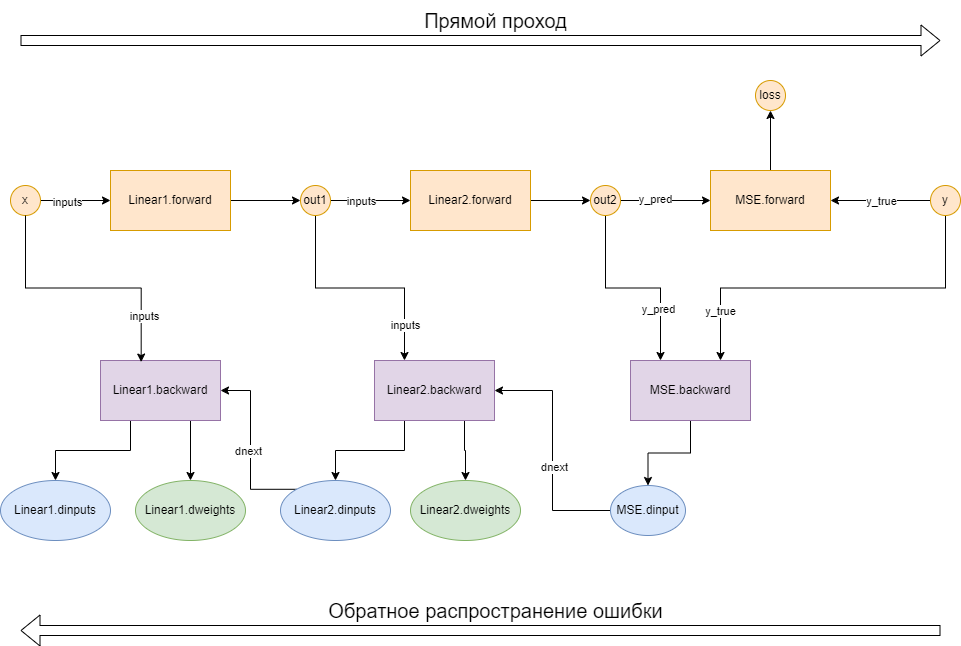

In [ ]:
import torch as th

class Linear:
    def __init__(self, n_features: int = 1, n_neurons: int = 1, seed: int | None = None, grad: bool = False, is_dinputs=True):
        if seed is not None:
            th.manual_seed(seed)
        # Добавьте дополнительный вес для сдвига
        # задайте requires_grad у этого тензора, чтобы иметь возможность протестировать
        # автоматическое дифференцирование от torch
        self.weights: TensorType["n_features_with_bias", "n_neurons"] = th.rand((n_features+1, n_neurons), requires_grad=grad)
        self.is_dinputs = is_dinputs

    def add_ones_col(self, inputs: TensorType["batch", "n_features"]) -> TensorType["batch", "n_features_with_bias"]:
        """Добавляет столбец из единиц в начало матрицы inputs"""
        nbatches = inputs.shape[0]
        first_col = th.ones(nbatches).view(nbatches,1)
        inputs_1 = th.cat((first_col, inputs),1)
        return inputs_1

    def forward(self, inputs: TensorType["batch", "n_features"]) -> TensorType["batch", "n_neurons"]:
        inputs_1 = self.add_ones_col(inputs)
        res = inputs_1 @ self.weights
        return res

    def backward(self, inputs: TensorType["batch", "n_features"], dnext: TensorType["batch", "n_neurons"]):
        #print(self.weights.shape)
        inputs_1 = self.add_ones_col(inputs)
        self.dweights: TensorType["n_features_with_bias", "n_neurons"] = inputs_1.T @ dnext
        # self.dbias = dnext
        if self.is_dinputs:
            self.dinputs = dnext @ self.weights[-1:,:].T

In [ ]:
class MSELoss:
    def forward(self, y_pred: TensorType["batch", "n_neurons"], y_true: TensorType["batch", "n_neurons"]) -> Scalar:
        self.loss = ((y_pred-y_true)**2).mean()
        return self.loss

    def backward(self, y_pred: TensorType["batch", "n_neurons"], y_true: TensorType["batch", "n_neurons"]) -> None:
        k = y_pred.shape[0]
        m = y_pred.shape[1]
        #print("los", y_pred.shape)
        self.dinput: TensorType["batch", "n_neurons"] = -2/k/m * (y_true-y_pred)

In [ ]:
import torch as th

th.manual_seed(42)
X = th.linspace(-1, 1, 100).view(-1, 1)
y = X.pow(2) + 0.2 * th.rand(X.size())
X.shape, y.shape

(torch.Size([100, 1]), torch.Size([100, 1]))

In [ ]:
dataset = TensorDataset(X, y)
loader = DataLoader(dataset, batch_size=16, shuffle=True)

for batch in loader:
    features, labels = batch
    print(features.shape)
    print(labels.shape)
    break

torch.Size([16, 1])
torch.Size([16, 1])


In [ ]:
neuron_1l = Linear(n_features=1, n_neurons=10, grad=False, is_dinputs=False)
neuron_2l = Linear(n_features=10, n_neurons=1, grad=False)
criterion = MSELoss()
lr = 0.001
preds = []

for epoch in range(1000):
    losses = []
    for batch in loader:
        features, y_true = batch
        #y_true = y_true

        #forward pass
        out_1 = neuron_1l.forward(features) #16,10
        out_2 = neuron_2l.forward(out_1) #16,1
        #loss func
        loss_i = criterion.forward(out_2, y_true) #scalar
        losses.append(loss_i)
        #backward pass
        criterion.backward(out_2, y_true)
        neuron_2l.backward(out_1, criterion.dinput) #out_1 (16,10)(11), criterion.dinput (16,1)
        neuron_1l.backward(features, neuron_2l.dinputs) #features (16,2), neuron_2l.dinputs(16,11)

        #обновление весов
        neuron_2l.weights -= lr * neuron_2l.dweights
        neuron_1l.weights -= lr * neuron_1l.dweights
    if epoch%300==0:
        print(f"epoch = {epoch}, mean loss ={np.mean(losses)}")
        preds.append(out_2)

epoch = 0, mean loss =3.0285441875457764
epoch = 300, mean loss =0.10223730653524399
epoch = 600, mean loss =0.09228386729955673
epoch = 900, mean loss =0.10898197442293167


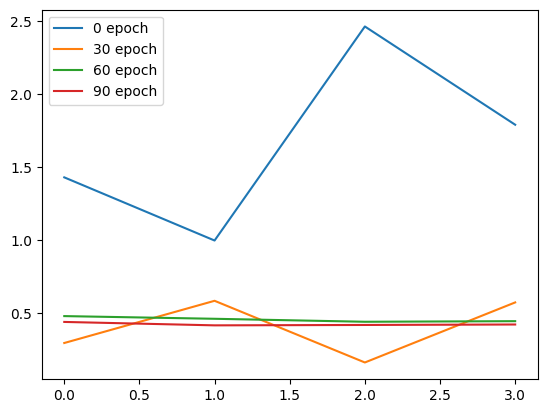

In [ ]:
import matplotlib.pyplot as plt
#конкретный батч((
plt.plot(preds[0], label='0 epoch')
plt.plot(preds[1], label='30 epoch')
plt.plot(preds[2], label='60 epoch')
plt.plot(preds[3], label='90 epoch')

plt.legend()
plt.show()

<p class="task" id="6"></p>

6\. Модель из предыдущей задачи является линейной и не способна качественно предсказать искомую зависимость. Для того, чтобы сделать модель нелинейной, в нейронных сетях используются функции активации. Для того, чтобы встроить такую функцию в процесс обратного распространения ошибки, необходимо реализовать соответствующий слой с методами `forward` и `backward`.

$$
f(x) = \max(0, x)
$$

$$
\frac{\partial L}{\partial x} = \frac{\partial L}{\partial f}\frac{\partial f}{\partial x} = \frac{\partial L}{\partial f}
\begin{cases}
1 & \text{если } x \ge 0 \\
0 & \text{если } x <  0
\end{cases}
$$

Здесь $L$ - это функция (слой), следующая за ReLU в потоке вычислений.

Реализуйте и обучите модель, состояющую из двух полносвязных слоев, разделенных функцией активации ReLU:
1. Полносвязный слой с 10 нейронами
2. Активация ReLU
3. Полносвязный слой с 1 нейроном

В процессе обучения сохраняйте промежуточные прогнозы моделей. Визуализируйте облако точек и прогнозы модели в начале, середине и после окончания процесса обучения (не обязательно три, можно взять больше промежуточных вариантов).




- [ ] Проверено на семинаре

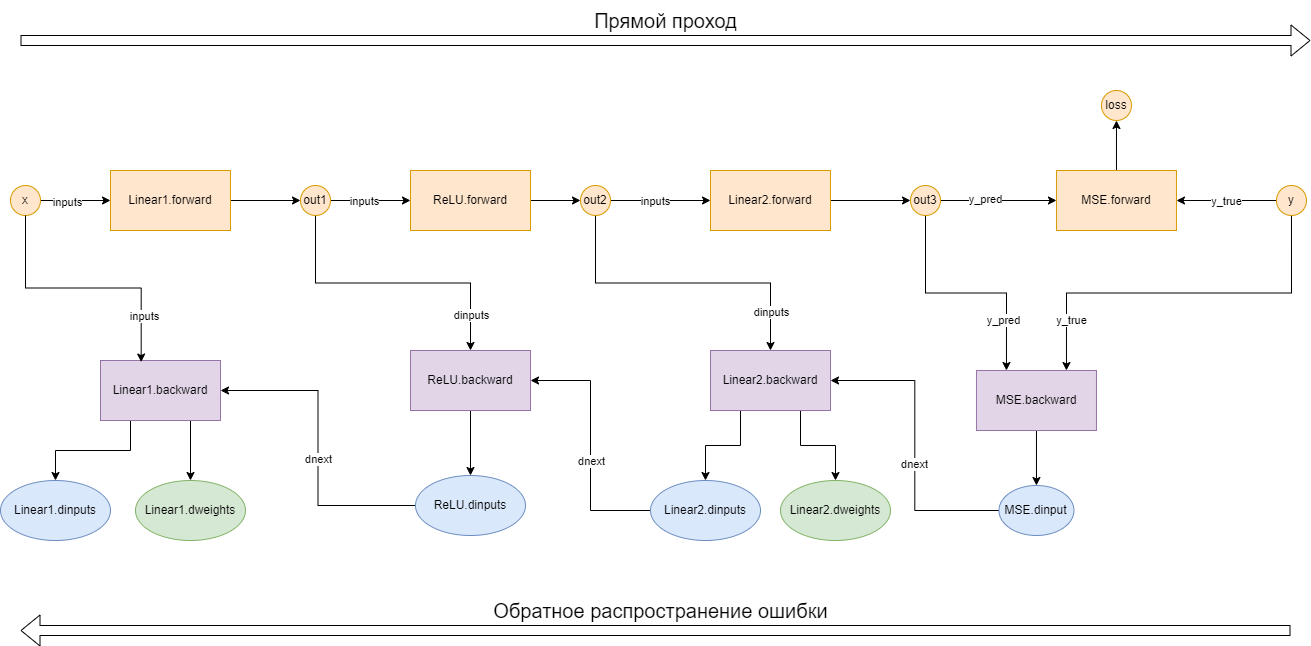

In [ ]:
class ReLU:
    def forward(self, inputs: TensorType["batch", "n_features"]) -> TensorType["batch", "n_features"]:
        self.relu = th.clamp(inputs, min=0)

    def backward(
        self,
        inputs: TensorType["batch", "n_features"],
        dvalues: TensorType["batch", "n_features"]
    ) -> TensorType["batch", "n_features"]:
        pass

In [ ]:
import torch as th

th.manual_seed(42)
X = th.linspace(-1, 1, 100).view(-1, 1)
y = X.pow(2) + 0.2 * th.rand(X.size())

In [ ]:
dataset = TensorDataset(X, y)
loader = DataLoader(dataset, batch_size=16, shuffle=True)

for batch in loader:
    features, labels = batch
    print(features.shape)
    print(labels.shape)
    break

In [ ]:
neuron_1l = Linear(n_features=1, n_neurons=10, grad=False, is_dinputs=False)
act_f = ReLU()
neuron_2l = Linear(n_features=10, n_neurons=1, grad=False)
criterion = MSELoss()
lr = 0.001
preds = []

for epoch in range(1000):
    losses = []
    for batch in loader:
        features, y_true = batch
        #y_true = y_true

        #forward pass
        out_1 = neuron_1l.forward(features) #16,10
        out_2 = act_f.forward(out_1)
        out_3 = neuron_2l.forward(out_1) #16,1

        #loss func
        loss_i = criterion.forward(out_2, y_true) #scalar
        losses.append(loss_i)
        #backward pass
        criterion.backward(out_2, y_true)
        neuron_2l.backward(out_1, criterion.dinput) #out_1 (16,10)(11), criterion.dinput (16,1)
        neuron_1l.backward(features, neuron_2l.dinputs) #features (16,2), neuron_2l.dinputs(16,11)

        #обновление весов
        neuron_2l.weights -= lr * neuron_2l.dweights
        neuron_1l.weights -= lr * neuron_1l.dweights
    if epoch%300==0:
        print(f"epoch = {epoch}, mean loss ={np.mean(losses)}")
        preds.append(out_2)